<img src="https://bioinf.nl/~davelangers/hanze.png" align="right" />

# <span id="0">Casus *Eiwitstructuur en -dynamica*</span>

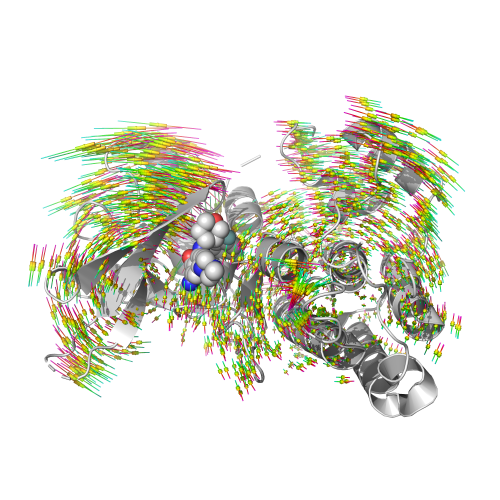

In deze casus maak je kennis met [Structuurvoorspelling](https://en.wikipedia.org/wiki/Protein_structure_prediction); het bepalen van een eiwitstructuur op basis van de sequentie van de aminozuren, en [Moleculaire Dynamica](https://en.wikipedia.org/wiki/Molecular_dynamics); een computersimulatie methode om het gedrag van moleculen te begrijpen in relatie tot de chemische en mechanische eigenschappen. Het doel van deze casus is inzicht krijgen in de werking van eiwitten als moleculaire machines en de tools om dat te bestuderen.

* **<a href="#Les-1:-Modelleren">Les 1: Modelleren met Alphafold en Gromacs</a>**

* **<a href="#Les-2:-Visualisatie">Les 2: Visualisatie van eiwitten en dynamica met PyMOL</a>**

* **<a href="#Les-3:-Analyse">Les 3: Beschrijvende analyse</a>**

* **<a href="#Les-4:-Vergelijking">Les 4: Vergelijkende analyse van wild-type en mutant</a>**

* **<a href="#Les-5:-Verslaglegging">Les 5: Visualisatie en verslaglegging</a>**


Als je uitgebreider aan de slag wil met een ander eiwit dan zou je dat kunnen doen in je verdiepend project.


 
<div class="alert alert-warning">
    
# ⚠️

**Opmerking:** Implementeer de functionaliteit in deze casus die gevraagd wordt onder de "Opdracht" kopjes (d.w.z. de python scripts en module) zelf gebruikmakend van alle [standaardmodules](https://docs.python.org/3/library/index.html) van python, maar maak geen wrappers rond bestaande externe modules, tenzij expliciet anders wordt vermeld; voor de "Toepassing" onderdelen (d.w.z. de notebooks) ben je vrij om te gebruiken wat je wil. Houd je werk bij in een (gezamenlijke) repository die je na afloop inlevert via BrightSpace.

</div>

***

## Les 1: Modelleren met Alphafold en Gromacs

### Inleiding

De functie van eiwitten wordt bepaald door de chemische en de mechanische eigenschappen, die volgen uit de structuur en uit de volgorde van aminozuren. Een mutatie kan de functie van een eiwit verstoren door de werking te remmen of juist door de activiteit te verhogen. Beide kunnen een rol spelen bij het ontstaan van kanker, bijvoorbeeld door uitval van beschermende (controle) eiwitten en door permanente activatie van groeifactoren. Een belangrijke rol in de laatste categorie wordt gespeeld door de familie van receptor tyrosine kinases, zoals bijvoorbeeld FGFR, VEGFR, ALK en ROS1. Dit zijn dimere receptoren, die geactiveerd worden door een groeifactor, maar waarbij mutaties er voor kunnen zorgen dat de receptor altijd aan staat. Er zijn gelukkig remmers beschikbaar voor kinases, maar bij langere behandeling treden er meer mutaties op die het actieve deel van de receptor, het kinase domein, ongevoelig maken voor de remmer en de activiteit weer verhogen.

Om het effect van een mutatie te kunnen beoordelen kan gebruik worden gemaakt van modelleren. Op basis van beschikbare structuren kan een structuur worden voorspeld voor de sequentie met de mutatie en worden vergeleken met de oorspronkelijke structuur. Een mutatie leidt evenwel niet altijd tot een direct duidelijk effect op de structuur. In dat geval moet ook gekeken worden naar veranderingen in het gedrag van het eiwit: de beweging. Daarvoor kan een computer model worden opgezet waarbij het eiwit zo nauwkeurig mogelijk wordt beschreven volgens de chemische en natuurkundige relaties van bindingen, ladingen, enz. Aan de hand van de wetten van Newton kan dan berekend worden hoe het zich over de tijd zal gedragen.

Vorig jaar (2024) is de Nobelprijs voor de chemie toegekend aan de makers van AlphaFold, een programma voor het voorspellen van eiwitstructuur op basis van de sequentie alleen. Dit is kort door de bocht een LLM dat de volgorde van aminozuren relateert aan de omgeving in de 3D structuur en dit omdraait om de structuur dan te voorspellen op basis van de aminozuurvolgorde. Dit is een enorme doorbraak voor modelleren, al is er wel kennis van eiwitten nodig om de validiteit en bruikbaarheid van de modellen te beoordelen. In deze les beginnen we met het zoeken van een mutatie om te karakteriseren en die te modelleren met AlphaFold. Gebruik hiervoor UniProt om te zoeken naar menselijke receptor tyrosine kinases en om in een receptor een maligne mutatie in het kinase domein te vinden.

Een aantal jaren eerder, in 2013, was de Nobelprijs voor de chemie echter al toegekend aan een aantal grondleggers van moleculaire dynamics als methode om het gedrag van moleculen te begrijpen. Deze techniek is sterk verbonden aan de Rijksuniversiteit Groningen, wat doorklinkt in één van de meest gebruikte programma's voor simulaties (en de allersnelste): Gromacs (Groningen Machine for Chemical Simulation). Hoewel het gebruik van dit programma en de workflow voor het doen van simulaties best ingewikkeld is, is het voor standaard systemen, zoals een eiwit in water, mogelijk om een standaard, geautomatiseerde workflow te gebruiken. Deze is beschikbaar via https://www.github.com/Tsjerk/gromit/ Let op! Hiervoor is een Linux omgeving nodig en moet de juiste programmatuur geinstalleerd zijn. Dit deel van de casus wordt daarom uitgevoerd op Assemblix.

Simulaties kosten veel rekenkracht. Veel van de berekeningen kunnen echter heel efficient op een GPU worden gedaan. De nieuwe machine van BIN/KCBBE is uitgerust met twee sterke GPUs en die zijn voor het eerste weekend van deze casus gereserveerd voor deze berekeningen.


### Opdracht

Maak voor deze casus een mapje op /students waarin je de data en de materialen verzamelt. Bespreek in je notebook elke stap die je neemt en voeg eventuele (Linux/Bash) scripts die je zelf schrijft toe als text en vergeet de plaatjes niet.

A. Modelleren

Zoek naar een receptor tyrosine kinase met een maligne mutatie of een mutatie die resistent maakt tegen remmers (inhibitor resistance) in het kinase domein. 

Ga naar [UniProt](https://www.uniprot.org) en selecteer de sequentie van het kinase domein.

Ga naar [AlphaFold](https://alphafoldserver.com/) en submit de sequentie (controle) en de sequentie waarin de mutatie is aangebracht. Let op, je hebt hiervoor een gmail account nodig. Als je niet zelf in wilt loggen, kan de docent dit doen.

Noteer welk eiwit en welke sequentie je hebt gekozen en geef een korte achtergrond/motivatie.

Als de run klaar is, download dan de structuren en open de .cif bestanden met Pymol om ze te bekijken. AlphaFold geeft vijf voorspellingen. Zijn ze allemaal gelijk? Probeer een plaatje te maken waarbij alle structuren aligned zijn (help `align`) en waarbij je kleurt volgens de kwaliteit van de voorspelling, de pLDDT (help `spectrum`). 


B. Simuleren

Selecteer van het wildtype en de mutant een structuur voor de simulatie. Gebruik het Linux/Bash script `gromit` (https://www.github.com/Tsjerk/gromit/, geïnstalleerd op `/homes/tsjerk/GIT/gromit/gromit.sh`) om de simulatie op te zetten. Lees eerst de help (`gromit.sh --help`). Zet dan de simulatie op met als force field `amber99sb-ildn` (`-ff amber99sb-ildn`) en een looptijd van 100 nanoseconde (`-time 100`). Stop de simulatie net voor de productierun, want die moet op de GPU (`-stop TPR`). Geef aan wanneer het script is afgelopen. De productie wordt gestart binnen de reservering van het systeem die op naam van de docent staat.

Voor deze opdracht hebben we gekozen voor het [tyrosine-protein kinase Yes eiwit](https://www.uniprot.org/uniprotkb/P07947/). Dit is een niet-receptor tyrosine kinase en behoort tot de Src-familie van kinases (SFK’s). Het eiwit wordt gecodeerd door het YES1-gen, dat vaak hoger tot expressie komt in tumoren, waaronder die in de long, borst, ovarium en huid. YES1 speelt een belangrijke rol bij het bevorderen van celproliferatie, celoverleving en de invasiviteit van cellen. Overexpressie van YES1 kan leiden tot resistentie tegen de standaardbehandeling van tyrosinekinase-gedreven kanker, namelijk tyrosinekinase inhibitors (TKI), maar ook tegen chemotherapeutische behandelingen ([Kook et al., 2024](https://doi.org/10.3390/ijms25031450)).

De variant die wij hebben gekozen bestaat uit een deletie die een frameshift veroorzaakt, wat leidt tot een aminozuurverandering van proline (P) naar asparagine (N) op positie 256 in het eiwit. Deze mutatie is geclassificeerd als 'high impact' volgens [The Cancer Genome Atlas Program](https://www.cancer.gov/ccg/research/genome-sequencing/tcga). Deze variant is geassocieerd met adenoom en adenocarcinoom. Voor meer details over de mutatie, zie de afbeelding hieronder.

![](imgs/YES1_mutation_variant.png)

AlphaFold geeft vijf verschillende voorspellingen van de eiwitstructuur op basis van de sequentie. Om te kijken of deze voorspellingen met elkaar overeenkomen, visualizeren we ze met PyMol. Eerst laden we alle vijf voorspellingen in, om ze vervolgens te alignen. Hiervoor gebruiken we `alignto`, zodat alle voorspellingen in één keer worden aligned.


```python
# align alle voorspellingen aan voorspelling 0
alignto fold_2025_12_12_14_04_mutand_model_0
```

```python
# align alle voorspellingen aan voorspelling 0
alignto fold_2025_12_12_14_04_wildtype_model_0
```

We doen dit voor zowel het wildtype, als het gemuteerde variant. Vervolgens kleuren we de voorspellingen gebaseerd op de 'predicted local distance difference test' (pLDDT):

```python
spectrum b, red_yellow_green_cyan_blue, minimum=50, maximum=90
```

De pLDDT is een lokale maat voor de ‘betrouwbaarheid’ (of 'confidence') van alle regio’s binnen het voorspelde eiwit. Deze score geeft weer hoe zeker het programma is dat de voorspelde vorm correct is. De schaal loopt van 0 tot 100, waarbij 100 staat voor een zeer hoge betrouwbaarheid (en dus een nauwkeurigere voorspelling) en 0 voor een zeer lage betrouwbaarheid (en een minder nauwkeurige voorspelling) ([Embl-Ebi, z.d.](https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/)).

## Wildtype
Eerst bekijken we de 5 voorspellingen van het wildtype. Het is gelijk duidelijk dat de voorspellingen sterk overeenkomen, vooral in het centrale gedeelte, hier liggen een aantal alpha-helices en beta-sheets, waarvan de locatie slechts lichtelijk verschilt tussen de voorspellingen. Dit gedeelte heeft dan ook een hoog pLDDT, dit is te zien aan de donkerblauwe kleur. Alle stukken met deze kleur hebben een pLDDT van > 90. De stukken waar weinig zekerheid lijkt te zijn bij de voorspellingen zijn de dunne 'slierten' om het eiwit heen. De kleur hier is rood, dat betekent een pLDDT van ~50 of lager. Deze stukken verschillen dan ook sterk onderling tussen de voorspellingen. Vandaar ook de 'sliert' vorm, omdat AlphaFold niet heeft kunnen bepalen hoe deze stukken er ruimtelijk uitzien. Opvallend is, dat de pLDDT lijkt te variëren van erg zeker tot erg onzeker, maar dat er weinig stukken zijn die hier tussen in vallen. Dit zijn dan vaak hele korte stukken, opvallend leek bijvoorbeeld de regio in de derde afbeelding. Hier was wel een duidelijke alfa-helix te zien, maar deze leek te verschillen tussen de voorspellingen.

![](imgs/wildtype_1.png)

![](imgs/wildtype_2.png)

![](imgs/wildtype_3.png)

## Mutant
Nu bekijken we de 5 voorspellingen van de gemuteerde variant. Over het algemeen lijkt de eiwitstructuur nog grotendeels hetzelfde als dat van het wildtype. Waarschijnlijk omdat de enkele mutatie niet genoeg is om de complete eiwitstructuur aan te tasten. Ook hier weer heeft het centrale deel een hoge pLDDT en zijn er slierten om het eiwit heen met een lage pLDDT. Opvallend is dat het gebied uit de derde afbeelding van wildtype 3 er anders uitziet bij het wildtype, hier lijken 2 kleine alfa-helices te vormen (wel met lage pLDDT). De mutatie zelf zit op plek 256 en is niet in de buurt van deze verandering. Dus toch zorgt de enkele mutatie voor structurele veranderingen verderop in het eiwit. Dit kan natuurlijk worden verklaard door de frameshift.

![](imgs/mutant_1.png)

![](imgs/mutant_2.png)

![](imgs/mutant_3.png)

Als we dan nu de eerste voorspelling van zowel het wildtype als de mutant vergelijken dan krijgen we het resultaat hieronder:

![](imgs/mutant_vs_wildtype.png)

De aminozuren om de mutatie heen zijn nog hetzelfde, alleen lijken ze niet heel netjes gealigned, dus de structuur lijkt iets veranderd. De mutatie zelf, van proline naar asparagine valt erg op omdat de structuren van deze aminozuren erg anders zijn. Zie de structuren hieronder, met links proline en rechts asparagine. In de pymol afbeelding is de ring van proline goed te zien en ook de zijketen van asparagine. Gezien de structuren zo anders zijn kunnen wij ons goed voorstellen dat deze mutatie grote gevolgen kan hebben. Op basis van structuur alleen is het echter lastig om hier verdere uitspraken over te doen, en zullen wij ook gaan kijken naar de beweging van het eiwit.

![](imgs/proline.png)
![](imgs/asparagine.png)



## Bronnen
- Kook, E., Chun, K., & Kim, D. (2024). Emerging Roles of YES1 in Cancer: The Putative Target in Drug Resistance. _International Journal Of Molecular Sciences_, _25_(3), 1450. https://doi.org/10.3390/ijms25031450
- Embl-Ebi. (z.d.). _pLDDT: Understanding local confidence | AlphaFold_. https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/

***

## Les 2: Visualisatie van eiwitten en dynamica met PyMOL

### Inleiding

PyMOL is een programma voor visualisatie en analyse van molecuulstructuren dat ook gebruikt kan worden voor (beperkte) analyse van dynamica. PyMOL heeft een Python interface die het mogelijk maakt om visualisaties en analyses te programmeren. Je hebt eerder in de opleiding kort kennis gemaakt met het programma voor het kijken naar eiwitten met verschillende representaties en kleuren. Er zijn vier manieren om PyMOL aan te sturen:

- De menus en de muis; voor het bekijken van het molecuul is de muis onmisbaar, maar de meeste menus kun je prima zonder.
- De PyMOL command line, waarmee je pymol commando's kunt uitvoeren (zie `help`), maar waar ook one-line Python statements gegeven kunnen worden.
- Een PyMOL script (`.pml`), een tekstbestand met daarin een serie PyMOL commando's die in volgorde worden uitgevoerd.
- Een Python script, waarmee complexere handelingen vormgegeven kunnen worden.




### Opdracht

Schrijf een PyMOL (`.pml`) of Python (`.py`) script dat de simulaties inlaadt (`load`), structure alignment uitvoert (`align` en `intra_fit`), de structuren kleurt (`color`), een geschikte kijkhoek instelt om de verschillen tussen wildtype en mutant goed te laten zien (`get_view` en `set_view`) en een plaatje (`.png`) en een filmpje (`.mp4`) maakt.


***

## Les 3: Beschrijvende analyse

### Inleiding



### Opdracht



***

## Les 4: Vergelijkende analyse van wild-type en mutant

### Inleiding



### Opdracht



***

&copy; 2025 - Tsjerk A. Wassenaar <t.a.wassenaar@pl.hanze.nl>